In [3]:
import numpy as np
import pandas as pd

In [4]:
from itertools import combinations
pd.set_option('display.max_columns', 100)

In [5]:
eq = pd.read_csv('data/03_equipment.csv', sep = ",")

In [6]:
data = pd.read_csv('data/02_Data_test.csv', sep = ';')

In [7]:
#positive_target = pd.read_csv('data/01_Facts.csv', sep = ',')

In [33]:
data.head()

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
0,5029,40798,158529599791,3.531111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220.0,280.0
1,7782,56870,158520145943,1.292900e+13,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45.0,105.0
2,7794,32226,158521798391,3.519940e+14,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0.0,60.0
3,7758,33528,158537830573,3.586270e+14,0,1369252802331,37.7895,55.7042,1158,OUTDOOR,210.0,270.0
4,5060,17568,158510204039,3.524581e+14,8,1369252803586,37.1900,55.8308,500,OUTDOOR,180.0,240.0


In [75]:
a = []
for lac in list(data['lac'].unique()):
    a.append((data[data['lac'] == lac].head(1)[['long', 'lat']].iloc[0, 0], data[data['lac'] == lac].head(1)[['long', 'lat']].iloc[0, 1]))

In [77]:
a;

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

In [81]:
a[0][0]

37.9305

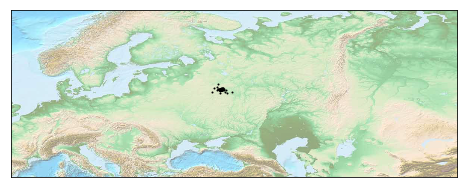

In [92]:
fig = plt.figure(figsize=(8, 10), edgecolor='w')
m = Basemap(projection='cyl', resolution=None,
            llcrnrlat=40, urcrnrlat=70,
            llcrnrlon=0, urcrnrlon=80, )
m.etopo(scale=1.5, alpha=0.5)

# Map (long, lat) to (x, y) for plotting
for i in a:
    x, y = m(i[0], i[1])
    plt.plot(x, y, 'ok', markersize=1)
#plt.text(x, y, ' Seattle', fontsize=12);

In [12]:
len(data['msisdn'])

174123

In [15]:
data['cell_type'].value_counts()

OUTDOOR    169912
INDOOR       2184
METRO        2027
Name: cell_type, dtype: int64

In [ ]:
ata['msisdn']

In [7]:
len(data['msisdn'].unique())

2361

In [ ]:
list_of_duplicates = []

In [ ]:
for i in range(len(data['msisdn'])):
    data

In [ ]:
data_sample 

In [181]:
data_small = data.head(74123)

In [175]:
df = pd.DataFrame(columns = col_0 + col_1)

In [152]:
col = data_small.columns
col_0 = ['lac0', 'cid0', 'msisdn0', 'imei0', 'event_type0', 'tstamp0', 'long0', 'lat0', \
       'max_dist0', 'cell_type0', 'start_angle0', 'end_angle0']
col_1 = ['lac1', 'cid1', 'msisdn1', 'imei1', 'event_type1', 'tstamp1', 'long1', 'lat1', \
       'max_dist1', 'cell_type1', 'start_angle1', 'end_angle1']

In [ ]:
for index in list(combinations(data_small.index,2)):
    
    df0 = pd.DataFrame(data_small.loc[index[0], :]).T.reset_index(drop=True)
    df1 = pd.DataFrame(data_small.loc[index[1], :]).T.reset_index(drop=True)
    df_temp = pd.concat([df0, df1], axis = 1)
    df_temp.columns = col_0 + col_1
    df = df.append(df_temp)

In [179]:
df

,lac0,cid0,msisdn0,imei0,event_type0,tstamp0,long0,lat0,max_dist0,cell_type0,start_angle0,end_angle0,lac1,cid1,msisdn1,imei1,event_type1,tstamp1,long1,lat1,max_dist1,cell_type1,start_angle1,end_angle1
0,5029,40798,158529599791,3.53111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220,280,7782,56870,158520145943,1.2929e+13,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45,105
0,5029,40798,158529599791,3.53111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220,280,7794,32226,158521798391,3.51994e+14,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0,60
0,5029,40798,158529599791,3.53111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220,280,7758,33528,158537830573,3.58627e+14,0,1369252802331,37.7895,55.7042,1158,OUTDOOR,210,270
0,5029,40798,158529599791,3.53111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220,280,5060,17568,158510204039,3.52458e+14,8,1369252803586,37.19,55.8308,500,OUTDOOR,180,240
0,7782,56870,158520145943,1.2929e+13,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45,105,7794,32226,158521798391,3.51994e+14,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0,60
0,7782,56870,158520145943,1.2929e+13,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45,105,7758,33528,158537830573,3.58627e+14,0,1369252802331,37.7895,55.7042,1158,OUTDOOR,210,270
0,7782,56870,158520145943,1.2929e+13,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45,105,5060,17568,158510204039,3.52458e+14,8,1369252803586,37.19,55.8308,500,OUTDOOR,180,240
0,7794,32226,158521798391,3.51994e+14,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0,60,7758,33528,158537830573,3.58627e+14,0,1369252802331,37.7895,55.7042,1158,OUTDOOR,210,270
0,7794,32226,158521798391,3.51994e+14,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0,60,5060,17568,158510204039,3.52458e+14,8,1369252803586,37.19,55.8308,500,OUTDOOR,180,240
0,7758,33528,158537830573,3.58627e+14,0,1369252802331,37.7895,55.7042,1158,OUTDOOR,210,270,5060,17568,158510204039,3.52458e+14,8,1369252803586,37.19,55.8308,500,OUTDOOR,180,240


In [107]:
df

,cell_type0,cell_type1,cid0,cid1,end_angle0,end_angle1,event_type0,event_type1,imei0,imei1,lac0,lac1,lat0,lat1,long0,long1,max_dist0,max_dist1,msisdn0,msisdn1,start_angle0,start_angle1,tstamp0,tstamp1,0,1,2,3,4
lac,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5029,NaN,NaN,NaN,NaN
cid,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40798,NaN,NaN,NaN,NaN
msisdn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,158529599791,NaN,NaN,NaN,NaN
imei,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.53111e+14,NaN,NaN,NaN,NaN
event_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
tstamp,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1369252800974,NaN,NaN,NaN,NaN
long,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.9305,NaN,NaN,NaN,NaN
lat,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.7815,NaN,NaN,NaN,NaN
max_dist,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2101,NaN,NaN,NaN,NaN
cell_type,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OUTDOOR,NaN,NaN,NaN,NaN


In [50]:
data_small

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
0,5029,40798,158529599791,3.531111e+14,0,1369252800974,37.9305,55.7815,2101,OUTDOOR,220.0,280.0
1,7782,56870,158520145943,1.292900e+13,5,1369252801396,37.4239,55.7426,2,OUTDOOR,45.0,105.0
2,7794,32226,158521798391,3.519940e+14,5,1369252802013,37.7034,55.5803,1125,OUTDOOR,0.0,60.0
3,7758,33528,158537830573,3.586270e+14,0,1369252802331,37.7895,55.7042,1158,OUTDOOR,210.0,270.0
4,5060,17568,158510204039,3.524581e+14,8,1369252803586,37.1900,55.8308,500,OUTDOOR,180.0,240.0


In [40]:
data[data['msisdn'] == 158530063945]

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
7471,7717,31137,158530063945,8.670070e+14,0,1369278960506,37.5842,55.6137,1349,OUTDOOR,90.0,150.0
11232,7717,7716,158530063945,8.670070e+14,8,1369285457592,37.5842,55.6137,665,OUTDOOR,120.0,180.0
20325,7717,31137,158530063945,8.670070e+14,8,1369297362516,37.5842,55.6137,1349,OUTDOOR,90.0,150.0
30765,7717,7716,158530063945,8.670070e+14,2,1369309596217,37.5842,55.6137,665,OUTDOOR,120.0,180.0
30969,7717,31137,158530063945,8.670070e+14,2,1369309844096,37.5842,55.6137,1349,OUTDOOR,90.0,150.0
42787,7717,7716,158530063945,8.670070e+14,2,1369322875301,37.5842,55.6137,665,OUTDOOR,120.0,180.0
42836,7717,31137,158530063945,8.670070e+14,8,1369322944463,37.5842,55.6137,1349,OUTDOOR,90.0,150.0
42843,7717,31132,158530063945,8.670070e+14,10,1369322954795,37.5842,55.6137,1450,OUTDOOR,120.0,180.0
45736,7717,27798,158530063945,8.670070e+14,2,1369326077832,37.5913,55.6133,1100,OUTDOOR,200.0,260.0
45757,7717,31137,158530063945,8.670070e+14,10,1369326102163,37.5842,55.6137,1349,OUTDOOR,90.0,150.0


In [ ]:
d

In [39]:
data[data['msisdn'] == 158528861599]

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
7395,7717,31137,158528861599,1.243901e+13,0,1369278754613,37.5842,55.6137,1349,OUTDOOR,90.0,150.0
8344,7717,7716,158528861599,1.243901e+13,0,1369280754147,37.5842,55.6137,665,OUTDOOR,120.0,180.0
9023,7717,7716,158528861599,1.243901e+13,3,1369281996520,37.5842,55.6137,665,OUTDOOR,120.0,180.0
19752,7754,10284,158528861599,1.243901e+13,0,1369296664866,37.5863,55.7394,500,OUTDOOR,270.0,330.0
19907,7745,8204,158528861599,1.243901e+13,0,1369296860438,37.5959,55.7686,587,OUTDOOR,210.0,270.0
41182,7745,10032,158528861599,1.243901e+13,0,1369321135723,37.6054,55.7661,500,OUTDOOR,60.0,120.0
42234,7736,790,158528861599,1.243901e+13,0,1369322236540,37.6223,55.6834,100,METRO,315.0,45.0
63280,7717,7716,158528861599,1.243901e+13,0,1369350437159,37.5842,55.6137,665,OUTDOOR,120.0,180.0
63673,7717,7716,158528861599,1.243901e+13,0,1369352375361,37.5842,55.6137,665,OUTDOOR,120.0,180.0
63706,7717,7716,158528861599,1.243901e+13,0,1369352532561,37.5842,55.6137,665,OUTDOOR,120.0,180.0


In [35]:
data[data['msisdn'] == 158528861653]

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
131602,7799,9705,158528861653,3.578930e+14,5,1369459240254,37.5788,55.7964,253,INDOOR,0.0,360.0
131606,7799,9705,158528861653,3.578930e+14,1,1369459245686,37.5788,55.7964,253,INDOOR,0.0,360.0


In [34]:
data[data['msisdn'] == 158530067653]

,lac,cid,msisdn,imei,event_type,tstamp,long,lat,max_dist,cell_type,start_angle,end_angle
8607,7782,48428,158530067653,1.303401e+13,0,1369281266860,37.4625,55.7214,50,OUTDOOR,170.0,230.0
8923,7752,30479,158530067653,1.303401e+13,0,1369281821169,37.5049,55.7309,1246,OUTDOOR,290.0,350.0
8966,7742,58364,158530067653,1.303401e+13,0,1369281894211,37.4842,55.7393,50,OUTDOOR,86.5,133.5
9311,7742,26211,158530067653,1.303401e+13,1,1369282509891,37.5392,55.7668,628,OUTDOOR,290.0,350.0
9894,7799,20136,158530067653,1.303401e+13,0,1369283494251,37.5876,55.7912,1108,OUTDOOR,330.0,30.0
17688,7799,9705,158530067653,1.303401e+13,1,1369294037018,37.5788,55.7964,253,INDOOR,0.0,360.0
20414,7799,9705,158530067653,1.303401e+13,10,1369297463477,37.5788,55.7964,253,INDOOR,0.0,360.0
25301,7799,7173,158530067653,1.303401e+13,2,1369303333463,37.5730,55.8007,449,OUTDOOR,85.0,145.0
31800,7799,9705,158530067653,1.303401e+13,8,1369310811017,37.5788,55.7964,253,INDOOR,0.0,360.0
37946,7799,21582,158530067653,1.303401e+13,10,1369317711384,37.5777,55.7975,109,OUTDOOR,90.0,150.0
